In [ ]:
# 1. Install dependencies
!pip install -q transformers datasets scikit-learn seaborn evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Logging: e43a19f0acb2d48ec5199bd3b99181eda808ea38
file_path = "/content/drive/MyDrive/SaravananSir/dataset.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()   # Remove trailing spaces
df = df.iloc[1:]                      # Skip first row of actual data
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

In [ ]:
# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# 📤 Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [ ]:
# 🔠 Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [ ]:
# 📦 Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# 🧠 Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 📈 Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    }


In [ ]:

# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",      # <-- add this line
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


In [ ]:
# 🏋️ Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-23-2798461883.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.043500,0.561274,0.938776,0.931669
2,0.024500,0.589973,0.949466,0.943814
3,0.014000,0.471940,0.956268,0.951701
4,0.000000,0.480787,0.955296,0.951083
5,0.001600,0.468880,0.957240,0.953549


TrainOutput(global_step=2570, training_loss=0.016707238106687592, metrics={'train_runtime': 361.3821, 'train_samples_per_second': 56.893, 'train_steps_per_second': 7.112, 'total_flos': 261816645931776.0, 'train_loss': 0.016707238106687592, 'epoch': 5.0})

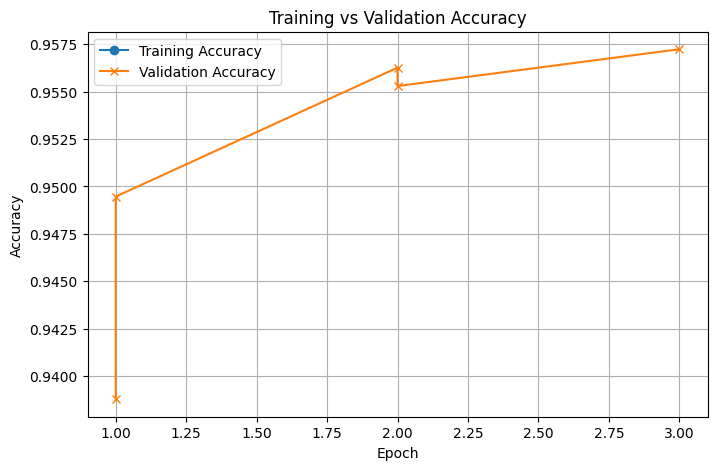

In [ ]:
# 📊 Evaluation
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9713    0.9883    0.9797       342
           1     0.9755    0.9522    0.9637       209
           2     0.9286    0.9333    0.9309       195
           3     0.9751    0.9682    0.9716       283

    accuracy                         0.9650      1029
   macro avg     0.9626    0.9605    0.9615      1029
weighted avg     0.9651    0.9650    0.9650      1029



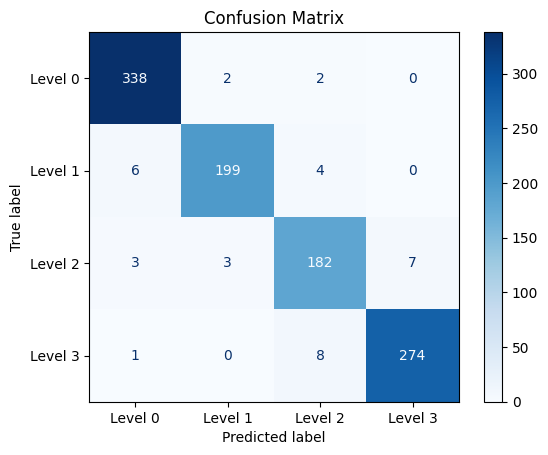

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 🔍 Inference function
def classify_response(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    pred_class = torch.argmax(outputs.logits, dim=1).item()
    return f"Predicted Severity Level: Level {pred_class}"

In [ ]:
# ✅ Try it out
sample = "This is a safe and filtered response."
print(classify_response(sample))

In [ ]:
# In your Colab Notebook
model_save_path = "/content/drive/MyDrive/SaravananSir/roberta_response_classifier"

# Save both model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

In [ ]:
# 🧪 Evaluate on training set to get training accuracy
train_metrics = trainer.evaluate(train_dataset=train_ds)
print("Training Metrics:", train_metrics)

TypeError: Trainer.evaluate() got an unexpected keyword argument 'train_dataset'